In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.losses import mse
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [3]:
batch_siz=64
iterations=5000 # epochs가 아닌 iterations
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

In [4]:
discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

In [5]:
generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

In [6]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

In [9]:
def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

1/1 [==============================] - 0s 99ms/step


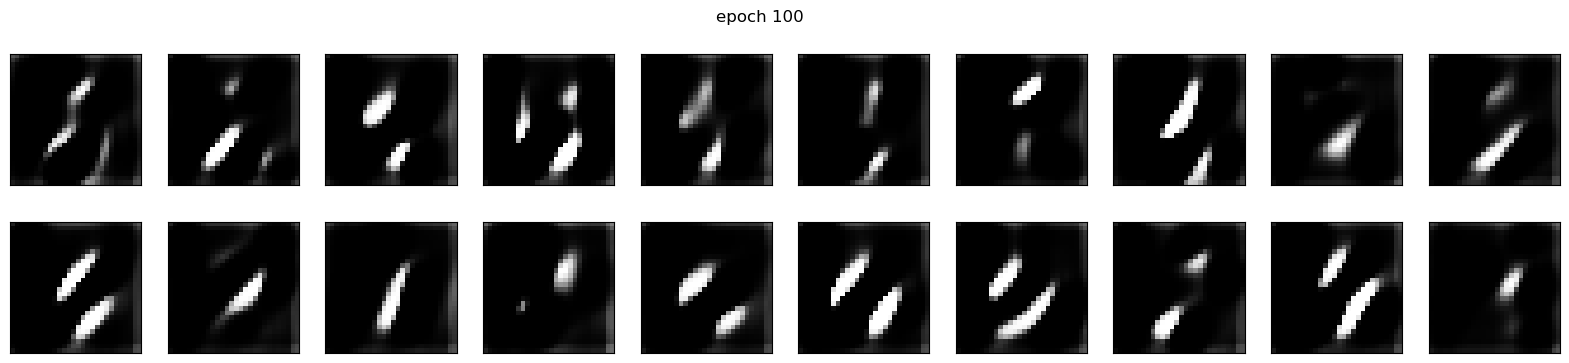

1/1 [==============================] - 0s 56ms/step


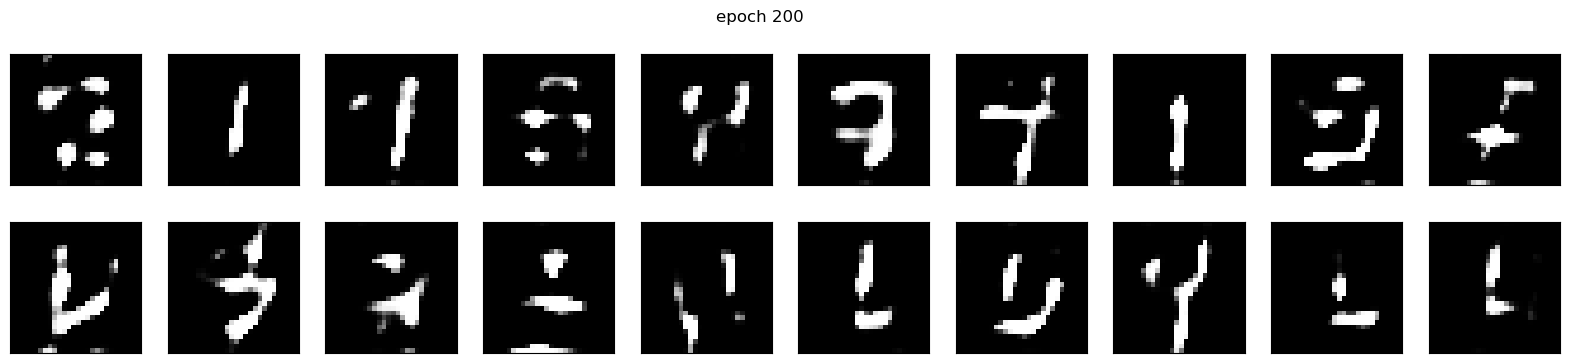

1/1 [==============================] - 0s 52ms/step


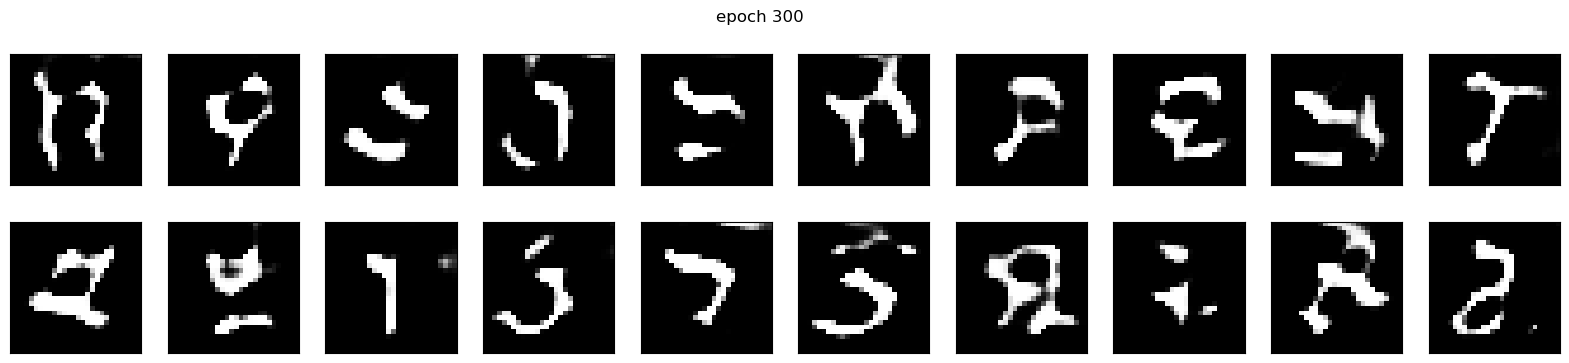

1/1 [==============================] - 0s 42ms/step


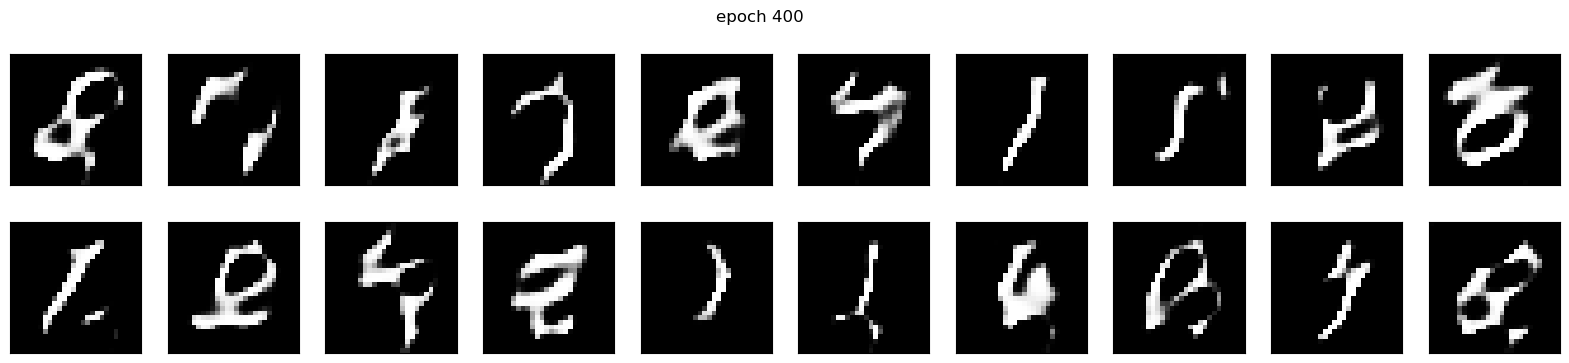

1/1 [==============================] - 0s 44ms/step


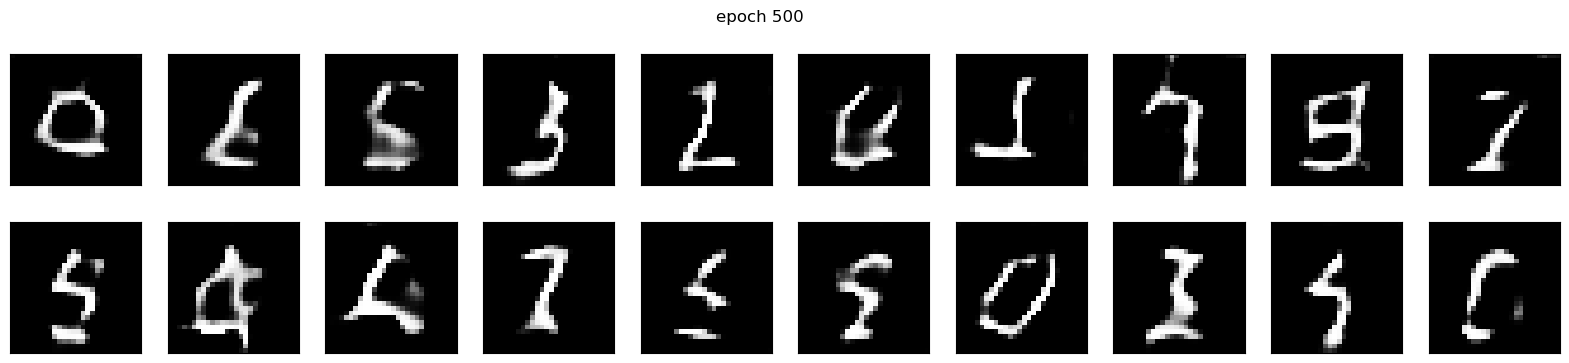

2/2 [==============================] - 1s 257ms/step


KeyboardInterrupt: 

In [10]:
for i in range(1, iterations+1): # 학습을 수행 (5000 iterations * 64 batch size / 60000 train size = 5.333 epochs)
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력 (batch_size*100=6400개 sample 학습시 마다)
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

## Measure the performance of discriminator network

In [ ]:
discriminator.evaluate(x_test,np.ones((len(x_test),1))) # test data에 대한 D network의 성능 확인

313/313 [==============================] - 2s 7ms/step - loss: 0.3819 - accuracy: 0.8352


[0.3819214701652527, 0.8352000117301941]

In [ ]:
p=np.random.normal(0,1,(len(x_test),zdim))
fake = generator.predict(p)
discriminator.evaluate(fake,np.zeros((len(x_test),1))) # fake data에 대한 D network의 성능 확인

313/313 [==============================] - 2s 6ms/step - loss: 0.5828 - accuracy: 0.7133


[0.5827659964561462, 0.7132999897003174]

In [ ]:
res = discriminator.predict(x_test)
print('accuracy:', np.sum(res>=0.5)/len(res)) 

313/313 [==============================] - 2s 6ms/step
accuracy: 0.8352


In [ ]:
p=np.random.normal(0,1,(len(x_test),zdim))
fake=generator.predict(p)
res = discriminator.predict(fake)
print('accuracy:', np.sum(res<0.5)/len(res)) 

313/313 [==============================] - 2s 6ms/step
accuracy: 0.7208


In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0     

In [ ]:
generator.summary()